# Home Credit Default Risk - LightGBM Pipeline

This notebook implements a complete ML pipeline with **two modes**:
- **TRAIN_MODE = True**: Full training + model saving
- **TRAIN_MODE = False**: Load saved models for inference only

## Pipeline Stages
1. **Data Loading** - Load 7 CSV tables
2. **Preprocessing** - Encoding, outlier handling, missing value marking
3. **Feature Engineering** - Derived features, aggregations, multi-table joins
4. **Model Training/Loading** - K-Fold CV with LightGBM or load saved models
5. **Output** - Predictions, feature importance, ROC curves, and training curves

In [24]:
# =============================================================================
# Environment Detection and Configuration
# =============================================================================
import os
import platform

def detect_environment():
    """Detect running environment: local Mac, Kaggle, or other."""
    if os.path.exists('/kaggle'):
        return 'kaggle'
    elif platform.system() == 'Darwin':
        return 'mac'
    else:
        return 'other'

ENVIRONMENT = detect_environment()
print(f"Detected environment: {ENVIRONMENT}")

# Set data paths based on environment
if ENVIRONMENT == 'kaggle':
    DATA_PATH = '/kaggle/input/home-credit-default-risk/'
    OUTPUT_PATH = '/kaggle/working/'
    MODEL_DIR = '/kaggle/working/saved_models/'
    LOG_DIR = '/kaggle/working/logs/'
else:  # mac or other (local)
    DATA_PATH = '../home-credit-default-risk/'
    OUTPUT_PATH = '../outputs/'
    MODEL_DIR = '../models/'
    LOG_DIR = '../outputs/logs/'

print(f"Data path: {DATA_PATH}")
print(f"Output path: {OUTPUT_PATH}")
print(f"Model directory: {MODEL_DIR}")
print(f"Log directory: {LOG_DIR}")

# Create necessary directories
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, "predictions"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, "visualizations"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, "exports"), exist_ok=True)

Detected environment: mac
Data path: ../home-credit-default-risk/
Output path: ../outputs/
Model directory: ../models/
Log directory: ../outputs/logs/


In [25]:
# =============================================================================
# GPU Detection for LightGBM
# =============================================================================
import subprocess

def detect_gpu():
    """Detect if NVIDIA GPU is available."""
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, timeout=10)
        if result.returncode == 0:
            return True, "NVIDIA GPU detected"
    except (FileNotFoundError, subprocess.TimeoutExpired):
        pass
    return False, "No GPU detected"

GPU_AVAILABLE, GPU_INFO = detect_gpu()
print(f"GPU Detection: {GPU_INFO}")

# =============================================================================
# Important Note about LightGBM GPU
# =============================================================================
# LightGBM GPU acceleration requires:
# 1. A GPU-enabled build of LightGBM (pip default is CPU-only)
# 2. OpenCL or CUDA libraries
#
# On Kaggle, even with GPU enabled, the pre-installed LightGBM is CPU version.
# GPU acceleration is more beneficial for XGBoost or CatBoost on Kaggle.
#
# For this notebook, we'll use CPU training which is still fast for LightGBM.
# =============================================================================

# Force CPU mode for reliable execution
USE_GPU = False
DEVICE_TYPE = 'cpu'

if GPU_AVAILABLE:
    print("\n⚠️ Note: GPU detected but LightGBM will use CPU.")
    print("   Reason: Kaggle's LightGBM is CPU-only build.")
    print("   This is normal - LightGBM is already very fast on CPU!")
else:
    print("\n→ Training will use CPU")

print(f"\nDevice for training: {DEVICE_TYPE.upper()}")

GPU Detection: No GPU detected

→ Training will use CPU

Device for training: CPU


In [ ]:
# =============================================================================
# Stage 1: Configuration & Data Loading
# =============================================================================

import numpy as np
import pandas as pd
import gc
import time
import re
import os
import joblib
import logging
from datetime import datetime
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# =============================================================================
# CONFIGURATION
# =============================================================================
TRAIN_MODE = True   # True: train new models, False: load saved models
DEBUG = False       # True: use 10000 rows for quick testing
NUM_ROWS = 10000 if DEBUG else None

# Paths are set by environment detection cell above
SUBMISSION_FILE = os.path.join(OUTPUT_PATH, 'submission_kernel02.csv')

# =============================================================================
# Logging Setup - Detailed epoch logging to file
# =============================================================================
log_filename = os.path.join(LOG_DIR, f'training_log_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log')

file_handler = logging.FileHandler(log_filename, encoding='utf-8')
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(logging.Formatter('%(asctime)s | %(levelname)s | %(message)s'))

train_logger = logging.getLogger('lightgbm_training')
train_logger.setLevel(logging.DEBUG)
# Clear existing handlers to avoid duplicates
train_logger.handlers.clear()
train_logger.addHandler(file_handler)

print(f"Mode: {'TRAINING' if TRAIN_MODE else 'INFERENCE'}")
print(f"Debug: {DEBUG}")
print(f"Log file: {log_filename}")

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    elapsed = time.time() - t0
    print(f"{title} - done in {elapsed:.0f}s")
    train_logger.info(f"{title} completed in {elapsed:.0f}s")

# Load all datasets
with timer("Loading all datasets"):
    application_train = pd.read_csv(f'{DATA_PATH}application_train.csv', nrows=NUM_ROWS)
    application_test = pd.read_csv(f'{DATA_PATH}application_test.csv', nrows=NUM_ROWS)
    bureau = pd.read_csv(f'{DATA_PATH}bureau.csv', nrows=NUM_ROWS)
    bureau_balance = pd.read_csv(f'{DATA_PATH}bureau_balance.csv', nrows=NUM_ROWS)
    previous_application = pd.read_csv(f'{DATA_PATH}previous_application.csv', nrows=NUM_ROWS)
    pos_cash_balance = pd.read_csv(f'{DATA_PATH}POS_CASH_balance.csv', nrows=NUM_ROWS)
    installments_payments = pd.read_csv(f'{DATA_PATH}installments_payments.csv', nrows=NUM_ROWS)
    credit_card_balance = pd.read_csv(f'{DATA_PATH}credit_card_balance.csv', nrows=NUM_ROWS)

print(f"Train samples: {len(application_train)}, Test samples: {len(application_test)}")
train_logger.info(f"Loaded data - Train: {len(application_train)}, Test: {len(application_test)}")

Mode: INFERENCE
Debug: False
Log file: ../outputs/logs/training_log_20260117_232922.log
Loading all datasets - done in 16s
Train samples: 307511, Test samples: 48744


In [27]:
# =============================================================================
# Stage 2: Data Preprocessing
# =============================================================================

def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

with timer("Preprocessing application data"):
    df = pd.concat([application_train, application_test], ignore_index=True)
    df = df[df['CODE_GENDER'] != 'XNA']
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], _ = pd.factorize(df[bin_feature])
    df, cat_cols = one_hot_encoder(df, nan_as_category=False)
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

with timer("Preprocessing bureau and bureau_balance"):
    bureau_balance, bb_cat = one_hot_encoder(bureau_balance, nan_as_category=True)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=True)

with timer("Preprocessing previous applications"):
    previous_application, prev_cat = one_hot_encoder(previous_application, nan_as_category=True)
    for col in ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 
                'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
        if col in previous_application.columns:
            previous_application[col].replace(365243, np.nan, inplace=True)

with timer("Preprocessing other tables"):
    pos_cash_balance, pos_cat = one_hot_encoder(pos_cash_balance, nan_as_category=True)
    installments_payments, ins_cat = one_hot_encoder(installments_payments, nan_as_category=True)
    credit_card_balance, cc_cat = one_hot_encoder(credit_card_balance, nan_as_category=True)

del application_train, application_test
gc.collect()
print(f"Preprocessed main df shape: {df.shape}")

Preprocessing application data - done in 1s
Preprocessing bureau and bureau_balance - done in 2s
Preprocessing previous applications - done in 1s
Preprocessing other tables - done in 1s
Preprocessed main df shape: (356251, 242)


In [28]:
# =============================================================================
# Stage 3: Feature Engineering
# =============================================================================

with timer("Creating application features"):
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

with timer("Creating bureau features"):
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        if col in bureau_balance.columns:
            bb_aggregations[col] = ['mean']
    bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bureau_balance, bb_agg
    gc.collect()
    
    num_aggregations = {}
    agg_mapping = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'], 'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'], 'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'], 'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'], 'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'], 'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'], 'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'], 'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    for col, aggs in agg_mapping.items():
        if col in bureau.columns:
            num_aggregations[col] = aggs
    cat_aggregations = {}
    for cat in bureau_cat:
        if cat in bureau.columns:
            cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        col_name = cat + "_MEAN"
        if col_name in bureau.columns:
            cat_aggregations[col_name] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    if 'CREDIT_ACTIVE_Active' in bureau.columns:
        active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
        if len(active) > 0:
            active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
            active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
            bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
            del active_agg
        del active
    if 'CREDIT_ACTIVE_Closed' in bureau.columns:
        closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
        if len(closed) > 0:
            closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
            closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
            bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
            del closed_agg
        del closed
    del bureau
    gc.collect()
    df = df.join(bureau_agg, how='left', on='SK_ID_CURR')
    del bureau_agg
    gc.collect()
    print(f"After bureau features: {df.shape}")

with timer("Creating previous application features"):
    previous_application['APP_CREDIT_PERC'] = previous_application['AMT_APPLICATION'] / previous_application['AMT_CREDIT']
    prev_num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'], 'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'], 'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'], 'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'], 'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'], 'CNT_PAYMENT': ['mean', 'sum'],
    }
    prev_num_aggregations = {k: v for k, v in prev_num_aggregations.items() if k in previous_application.columns}
    cat_aggregations = {cat: ['mean'] for cat in prev_cat if cat in previous_application.columns}
    prev_agg = previous_application.groupby('SK_ID_CURR').agg({**prev_num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    if 'NAME_CONTRACT_STATUS_Approved' in previous_application.columns:
        approved = previous_application[previous_application['NAME_CONTRACT_STATUS_Approved'] == 1]
        if len(approved) > 0:
            approved_agg = approved.groupby('SK_ID_CURR').agg(prev_num_aggregations)
            approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
            prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
            del approved_agg
        del approved
    if 'NAME_CONTRACT_STATUS_Refused' in previous_application.columns:
        refused = previous_application[previous_application['NAME_CONTRACT_STATUS_Refused'] == 1]
        if len(refused) > 0:
            refused_agg = refused.groupby('SK_ID_CURR').agg(prev_num_aggregations)
            refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
            prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
            del refused_agg
        del refused
    del previous_application
    gc.collect()
    df = df.join(prev_agg, how='left', on='SK_ID_CURR')
    del prev_agg
    gc.collect()
    print(f"After previous application features: {df.shape}")

with timer("Creating POS cash features"):
    aggregations = {'MONTHS_BALANCE': ['max', 'mean', 'size'], 'SK_DPD': ['max', 'mean'], 'SK_DPD_DEF': ['max', 'mean']}
    aggregations = {k: v for k, v in aggregations.items() if k in pos_cash_balance.columns}
    for cat in pos_cat:
        if cat in pos_cash_balance.columns:
            aggregations[cat] = ['mean']
    pos_agg = pos_cash_balance.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    pos_agg['POS_COUNT'] = pos_cash_balance.groupby('SK_ID_CURR').size()
    del pos_cash_balance
    gc.collect()
    df = df.join(pos_agg, how='left', on='SK_ID_CURR')
    del pos_agg
    gc.collect()
    print(f"After POS cash features: {df.shape}")

with timer("Creating installments features"):
    installments_payments['PAYMENT_PERC'] = installments_payments['AMT_PAYMENT'] / installments_payments['AMT_INSTALMENT']
    installments_payments['PAYMENT_DIFF'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']
    installments_payments['DPD'] = installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
    installments_payments['DBD'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']
    installments_payments['DPD'] = installments_payments['DPD'].apply(lambda x: x if x > 0 else 0)
    installments_payments['DBD'] = installments_payments['DBD'].apply(lambda x: x if x > 0 else 0)
    ins_aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'], 'DPD': ['max', 'mean', 'sum'], 'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'], 'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'], 'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    ins_aggregations = {k: v for k, v in ins_aggregations.items() if k in installments_payments.columns}
    for cat in ins_cat:
        if cat in installments_payments.columns:
            ins_aggregations[cat] = ['mean']
    ins_agg = installments_payments.groupby('SK_ID_CURR').agg(ins_aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    ins_agg['INSTAL_COUNT'] = installments_payments.groupby('SK_ID_CURR').size()
    del installments_payments
    gc.collect()
    df = df.join(ins_agg, how='left', on='SK_ID_CURR')
    del ins_agg
    gc.collect()
    print(f"After installments features: {df.shape}")

with timer("Creating credit card features"):
    if 'SK_ID_PREV' in credit_card_balance.columns:
        credit_card_balance.drop(['SK_ID_PREV'], axis=1, inplace=True)
    numeric_cols = credit_card_balance.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != 'SK_ID_CURR']
    cc_agg = credit_card_balance.groupby('SK_ID_CURR')[numeric_cols].agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    cc_agg['CC_COUNT'] = credit_card_balance.groupby('SK_ID_CURR').size()
    del credit_card_balance
    gc.collect()
    df = df.join(cc_agg, how='left', on='SK_ID_CURR')
    del cc_agg
    gc.collect()

df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
print(f"Final df shape after all features: {df.shape}")

Creating application features - done in 0s
After bureau features: (356251, 363)
Creating bureau features - done in 4s
After previous application features: (356251, 612)
Creating previous application features - done in 5s
After POS cash features: (356251, 630)
Creating POS cash features - done in 3s
After installments features: (356251, 656)
Creating installments features - done in 7s
Creating credit card features - done in 3s
Final df shape after all features: (356251, 757)


In [29]:
# =============================================================================
# Stage 4: Model Training OR Loading
# =============================================================================
import lightgbm as lgb
import datetime

# Generate unique timestamp for this run (used for model saving and output files)
run_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"Run Timestamp: {run_timestamp}")

# =============================================================================
# Custom Callback: Log every epoch to file, print every 50 to console
# =============================================================================
class TrainingLogger:
    """Log every epoch to file, print every N epochs to console."""
    def __init__(self, logger, fold_num, console_period=50):
        self.logger = logger
        self.fold_num = fold_num
        self.console_period = console_period
        self.start_time = None
    
    def __call__(self, env):
        if self.start_time is None:
            self.start_time = time.time()
        
        iteration = env.iteration + 1
        train_auc = valid_auc = None
        
        for data_name, eval_name, result, _ in env.evaluation_result_list:
            if data_name == 'train' and eval_name == 'auc':
                train_auc = result
            elif data_name == 'valid' and eval_name == 'auc':
                valid_auc = result
        
        # Log EVERY epoch to file
        elapsed = time.time() - self.start_time
        train_logger.debug(f"Fold {self.fold_num} | Epoch {iteration:5d} | Train AUC: {train_auc:.6f} | Valid AUC: {valid_auc:.6f} | Time: {elapsed:.1f}s")
        
        # Print every 50 epochs to console
        if iteration % self.console_period == 0:
            print(f"  [Fold {self.fold_num}] Epoch {iteration:5d}: Train={train_auc:.6f}, Valid={valid_auc:.6f}")

# Split data
train_df = df[df['TARGET'].notnull()].copy()
test_df = df[df['TARGET'].isnull()].copy()
feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
print(f"Number of features: {len(feats)}")

del df
gc.collect()

num_folds = 3 if DEBUG else 10

# =============================================================================
# LightGBM Parameters - Native API with proper GPU support
# =============================================================================
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 34,
    'learning_rate': 0.02,
    'feature_fraction': 0.9497036,
    'bagging_fraction': 0.8715623,
    'bagging_freq': 1,
    'max_depth': 8,
    'lambda_l1': 0.041545473,
    'lambda_l2': 0.0735294,
    'min_split_gain': 0.0222415,
    'min_child_weight': 39.3259775,
    'verbose': -1,
    'num_threads': 4,
}

# Add GPU or CPU specific parameters
if USE_GPU:
    lgb_params['device_type'] = 'gpu'
    lgb_params['gpu_platform_id'] = 0
    lgb_params['gpu_device_id'] = 0
    lgb_params['num_threads'] = 1  # GPU typically uses single thread for data loading
    print("\n✓ GPU acceleration ENABLED (using lgb.train native API)")
    train_logger.info("GPU acceleration enabled with native API")
else:
    lgb_params['device_type'] = 'cpu'
    print("\n→ Training on CPU")
    train_logger.info("Training on CPU")

if TRAIN_MODE:
    print("\n" + "="*60)
    print("TRAINING MODE: Training new models")
    print("="*60)
    train_logger.info("="*60)
    train_logger.info(f"TRAINING MODE | Folds: {num_folds} | Device: {lgb_params['device_type'].upper()}")
    train_logger.info("="*60)
    
    folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)
    oof_preds = np.zeros(train_df.shape[0])
    oof_fold_id = np.zeros(train_df.shape[0], dtype=int)  # Track fold assignment for each sample
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    training_history = []
    fold_results = []
    models = []
    
    with timer(f"Training {num_folds}-Fold LightGBM"):
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
            fold_start = time.time()
            print(f"\n--- Fold {n_fold + 1}/{num_folds} ---")
            train_logger.info(f"\n{'='*40}")
            train_logger.info(f"Fold {n_fold + 1} | Train: {len(train_idx)}, Valid: {len(valid_idx)}")
            
            train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
            valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
            
            # Create LightGBM Dataset objects (native API)
            lgb_train = lgb.Dataset(train_x, label=train_y)
            lgb_valid = lgb.Dataset(valid_x, label=valid_y, reference=lgb_train)
            
            # Custom training logger callback
            training_callback = TrainingLogger(train_logger, n_fold + 1, console_period=50)
            
            # Store evaluation results
            evals_result = {}
            
            # Train using native API
            model = lgb.train(
                lgb_params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=[lgb_train, lgb_valid],
                valid_names=['train', 'valid'],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=200),
                    lgb.record_evaluation(evals_result),
                    training_callback
                ]
            )
            
            # Save model
            # Save model with timestamp subdirectory
            run_model_dir = os.path.join(MODEL_DIR, f'run_{run_timestamp}')
            os.makedirs(run_model_dir, exist_ok=True)
            model_path = os.path.join(run_model_dir, f'lgbm_fold_{n_fold}.txt')
            model.save_model(model_path)
            models.append(model)
            
            training_history.append({
                'fold': n_fold + 1,
                'train_auc': evals_result['train']['auc'],
                'valid_auc': evals_result['valid']['auc'],
                'best_iteration': model.best_iteration
            })
            
            # Predictions
            valid_preds = model.predict(valid_x, num_iteration=model.best_iteration)
            oof_preds[valid_idx] = valid_preds
            oof_fold_id[valid_idx] = n_fold + 1  # Record which fold this sample belongs to
            sub_preds += model.predict(test_df[feats], num_iteration=model.best_iteration) / num_folds
            
            fold_auc = roc_auc_score(valid_y, valid_preds)
            fold_results.append({
                'fold': n_fold + 1,
                'y_true': valid_y.values,
                'y_pred': valid_preds,
                'auc': fold_auc
            })
            
            # Feature importance (gain and split)
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = model.feature_importance(importance_type='gain')
            fold_importance_df["importance_gain"] = model.feature_importance(importance_type='gain')
            fold_importance_df["importance_split"] = model.feature_importance(importance_type='split')
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            
            fold_time = time.time() - fold_start
            print(f'Fold {n_fold + 1:2d} AUC: {fold_auc:.6f} | Best iter: {model.best_iteration} | Time: {fold_time:.0f}s')
            train_logger.info(f"Fold {n_fold + 1} DONE: AUC={fold_auc:.6f}, Best={model.best_iteration}, Time={fold_time:.0f}s")
            
            del train_x, train_y, valid_x, valid_y, lgb_train, lgb_valid
            gc.collect()
    
    # Save feature list for inference
    joblib.dump(feats, os.path.join(MODEL_DIR, 'feature_list.pkl'))
    
    full_auc = roc_auc_score(train_df['TARGET'], oof_preds)
    print(f'\nFull OOF AUC: {full_auc:.6f}')
    print(f'Models saved to: {MODEL_DIR}')
    train_logger.info(f"\nFINAL OOF AUC: {full_auc:.6f}")
    train_logger.info(f"Models saved to: {MODEL_DIR}")
    
    train_targets = train_df['TARGET'].values

else:
    print("\n" + "="*60)
    print("INFERENCE MODE: Loading saved models with OOF evaluation")
    print("="*60)
    
    saved_feats = joblib.load(os.path.join(MODEL_DIR, 'feature_list.pkl'))
    
    # Check for missing features in both train and test
    missing_feats_test = [f for f in saved_feats if f not in test_df.columns]
    missing_feats_train = [f for f in saved_feats if f not in train_df.columns]
    
    if missing_feats_test:
        print(f"Warning: {len(missing_feats_test)} features missing in test, filling with 0")
        for f in missing_feats_test:
            test_df[f] = 0
    if missing_feats_train:
        print(f"Warning: {len(missing_feats_train)} features missing in train, filling with 0")
        for f in missing_feats_train:
            train_df[f] = 0
    
    # Use the SAME KFold split as training for OOF evaluation
    folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)
    oof_preds = np.zeros(train_df.shape[0])
    oof_fold_id = np.zeros(train_df.shape[0], dtype=int)  # Track fold assignment for each sample
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    fold_results = []
    models = []
    
    with timer(f"Loading {num_folds} models and generating OOF predictions"):
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[saved_feats], train_df['TARGET'])):
            fold_start = time.time()
            model_path = os.path.join(MODEL_DIR, f'lgbm_fold_{n_fold}.txt')
            
            if not os.path.exists(model_path):
                print(f'Warning: Not found: {model_path}')
                continue
            
            # Load model
            model = lgb.Booster(model_file=model_path)
            models.append(model)
            
            # Get validation data for this fold
            valid_x = train_df[saved_feats].iloc[valid_idx]
            valid_y = train_df['TARGET'].iloc[valid_idx]
            
            # OOF predictions
            valid_preds = model.predict(valid_x)
            oof_preds[valid_idx] = valid_preds
            oof_fold_id[valid_idx] = n_fold + 1  # Record fold assignment
            
            # Test predictions
            sub_preds += model.predict(test_df[saved_feats]) / num_folds
            
            # Calculate fold AUC
            fold_auc = roc_auc_score(valid_y, valid_preds)
            fold_results.append({
                'fold': n_fold + 1,
                'y_true': valid_y.values,
                'y_pred': valid_preds,
                'auc': fold_auc
            })
            
            # Extract feature importance from loaded model (gain and split)
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = saved_feats
            fold_importance_df["importance"] = model.feature_importance(importance_type='gain')
            fold_importance_df["importance_gain"] = model.feature_importance(importance_type='gain')
            fold_importance_df["importance_split"] = model.feature_importance(importance_type='split')
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            
            fold_time = time.time() - fold_start
            print(f'Fold {n_fold + 1:2d} AUC: {fold_auc:.6f} | Time: {fold_time:.1f}s')
    
    full_auc = roc_auc_score(train_df['TARGET'], oof_preds)
    print(f'\nFull OOF AUC: {full_auc:.6f}')
    print(f'Loaded {len(models)} models')
    
    train_targets = train_df['TARGET'].values
    training_history = None  # Not available in inference mode

test_df['TARGET'] = sub_preds
submission_df = test_df[['SK_ID_CURR', 'TARGET']]

Train shape: (307507, 757), Test shape: (48744, 757)
Number of features: 755

→ Training on CPU

INFERENCE MODE: Loading saved models with OOF evaluation
Fold  1 AUC: 0.794831 | Time: 1.3s
Fold  2 AUC: 0.792252 | Time: 2.0s
Fold  3 AUC: 0.786168 | Time: 1.9s
Fold  4 AUC: 0.795219 | Time: 1.6s
Fold  5 AUC: 0.798829 | Time: 2.0s
Fold  6 AUC: 0.787432 | Time: 1.7s
Fold  7 AUC: 0.791894 | Time: 2.2s
Fold  8 AUC: 0.792002 | Time: 2.5s
Fold  9 AUC: 0.797503 | Time: 2.6s
Fold 10 AUC: 0.793113 | Time: 2.4s
Loading 10 models and generating OOF predictions - done in 20s

Full OOF AUC: 0.792886
Loaded 10 models


Run Timestamp: 20260117_233028
Submission saved to: ../outputs/predictions/submission_kernel02_20260117_233028.csv
Shape: (48744, 2)
Predictions range: [0.0016, 0.7771]
Saving submission file - done in 0s
  Saved logs with suffix: _20260117_233028.csv
Saving evaluation data for later visualization - done in 0s
  Saved: ../outputs/visualizations/lgbm_importances01_20260117_233028.png


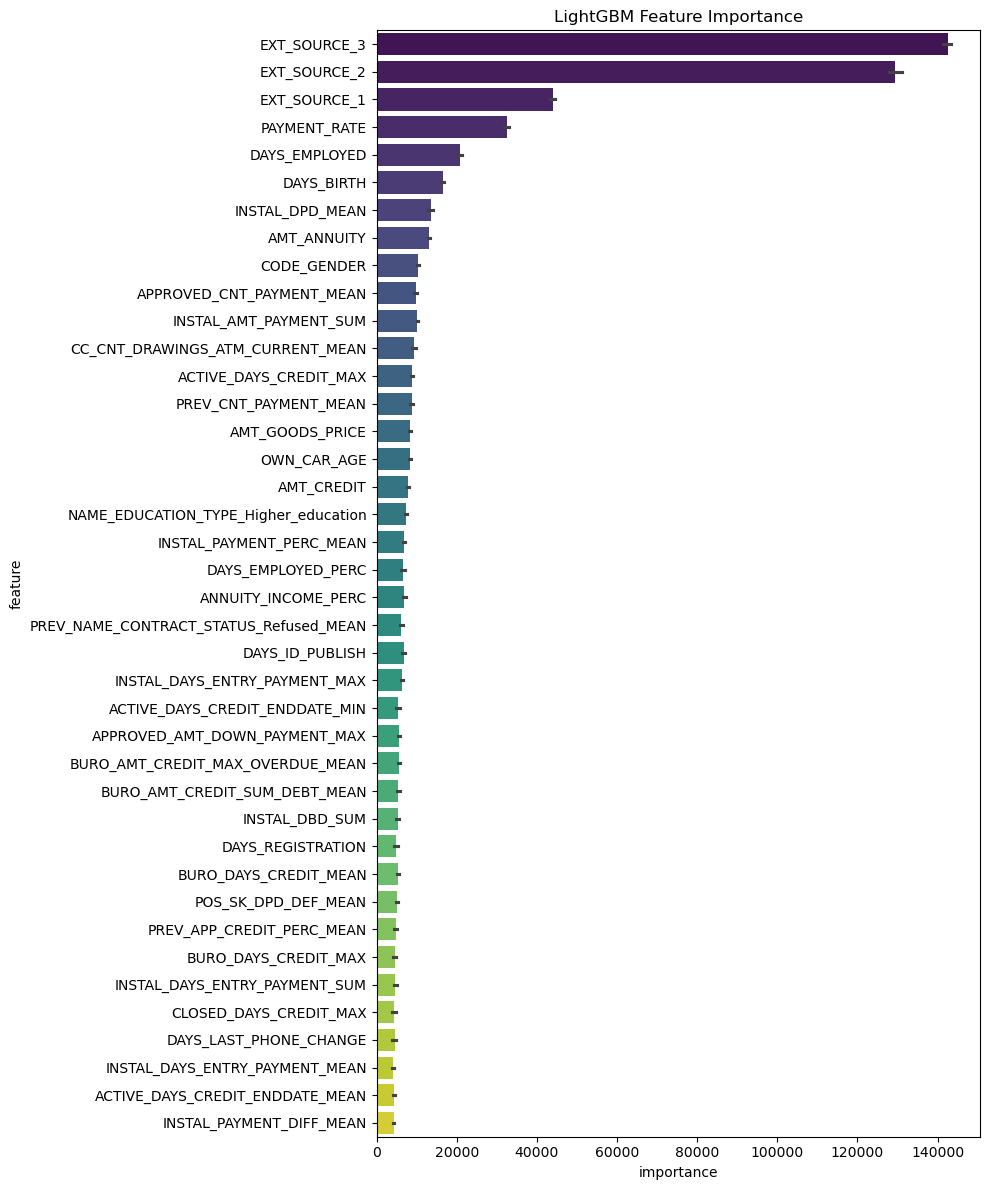

Generating feature importance - done in 1s
  Saved: ../outputs/visualizations/roc_curves_per_fold_20260117_233028.png


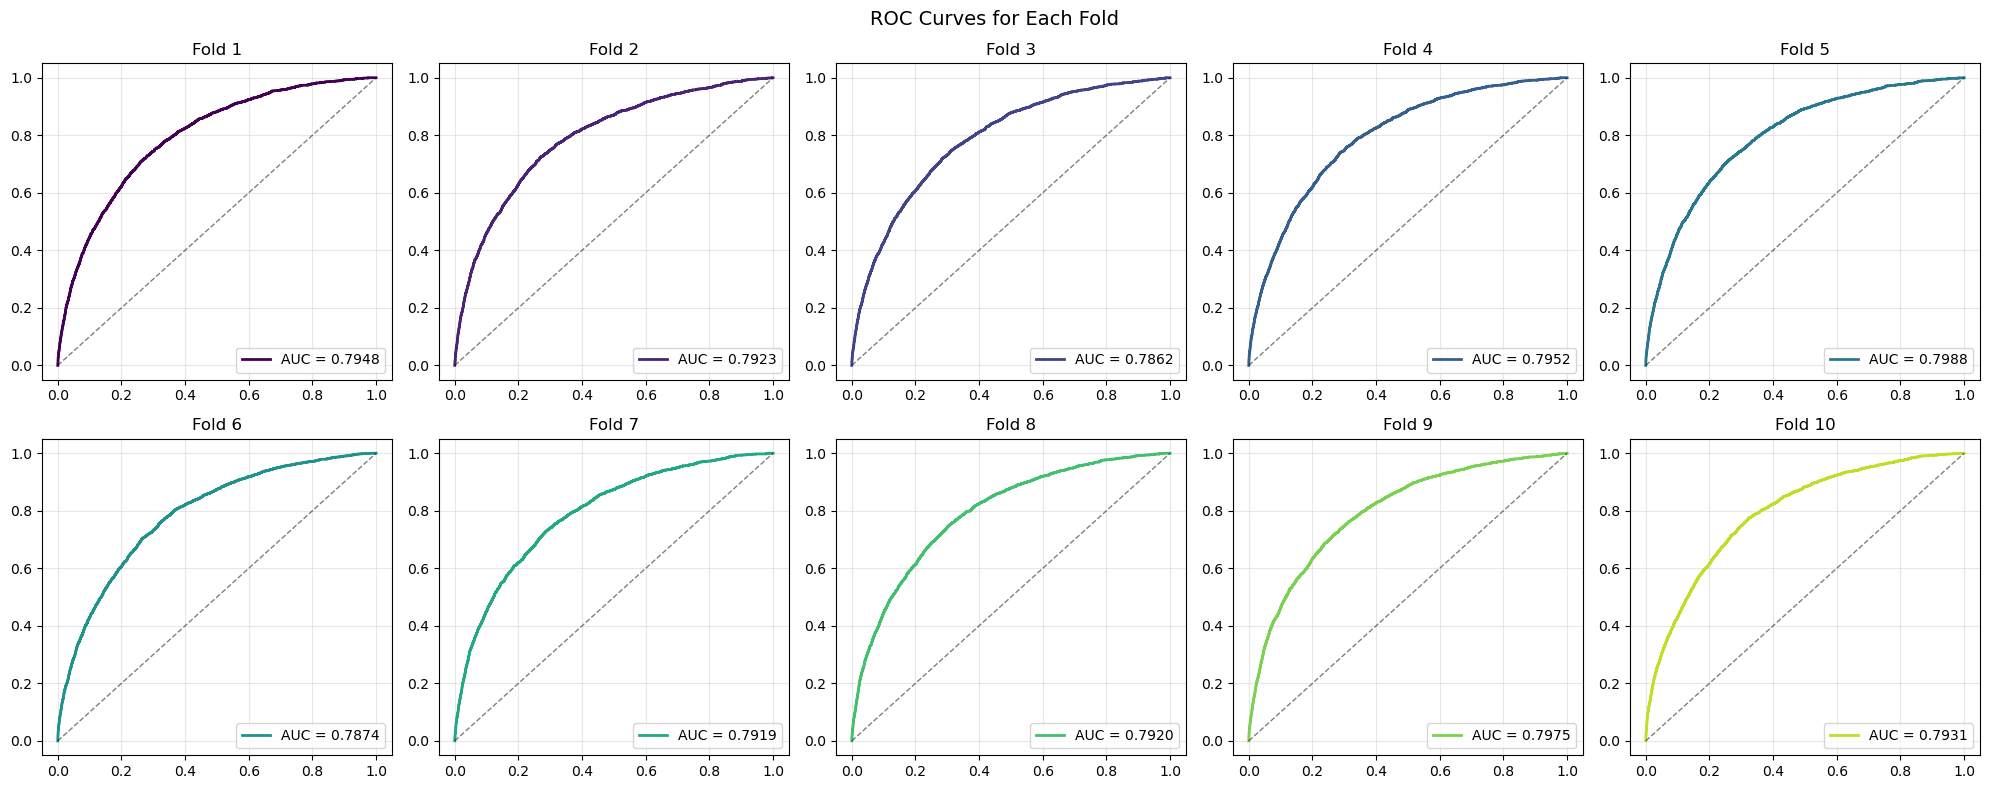

Generating per-fold ROC curves - done in 1s
  Saved: ../outputs/visualizations/roc_curve_20260117_233028.png


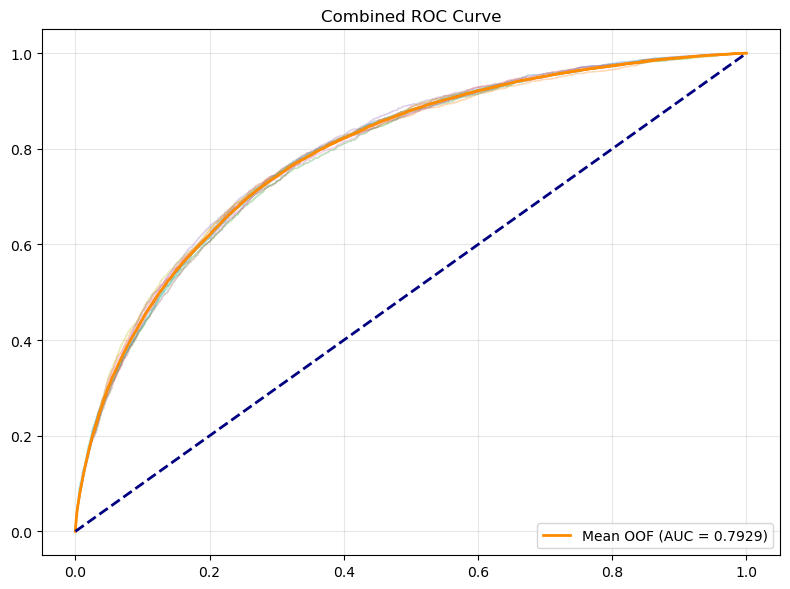

Generating combined ROC curve - done in 0s

EVALUATION SUMMARY
  Fold  1: AUC = 0.794831
  Fold  2: AUC = 0.792252
  Fold  3: AUC = 0.786168
  Fold  4: AUC = 0.795219
  Fold  5: AUC = 0.798829
  Fold  6: AUC = 0.787432
  Fold  7: AUC = 0.791894
  Fold  8: AUC = 0.792002
  Fold  9: AUC = 0.797503
  Fold 10: AUC = 0.793113

  Mean Fold AUC: 0.792925
  OOF AUC:       0.792886

Output files created with timestamp: 20260117_233028


In [30]:
# =============================================================================
# Stage 5: Output & Visualization
# =============================================================================

# Note: run_timestamp is already defined in Stage 4
print(f"Using Run Timestamp: {run_timestamp}")

# Create visualization directory
VIS_DIR = os.path.join(OUTPUT_PATH, "visualizations")
os.makedirs(VIS_DIR, exist_ok=True)

# Save submission
with timer("Saving submission file"):
    sub_file = f"submission_kernel02_{run_timestamp}.csv"
    sub_path = os.path.join(OUTPUT_PATH, "predictions", sub_file)
    submission_df.to_csv(sub_path, index=False)
    print(f"Submission saved to: {sub_path}")
    print(f"Shape: {submission_df.shape}")
    print(f"Predictions range: [{submission_df['TARGET'].min():.4f}, {submission_df['TARGET'].max():.4f}]")

# Save raw data for later visualization customization
if feature_importance_df is not None and fold_results is not None:
    with timer("Saving evaluation data for later visualization"):
        # Save feature importance
        feature_importance_df.to_csv(os.path.join(OUTPUT_PATH, f"logs/feature_importance_{run_timestamp}.csv"), index=False)
        
        # Save fold results (AUCs)
        fold_auc_df = pd.DataFrame([{"fold": fr["fold"], "auc": fr["auc"]} for fr in fold_results])
        fold_auc_df.to_csv(os.path.join(OUTPUT_PATH, f"logs/fold_results_{run_timestamp}.csv"), index=False)
        
        # Save OOF predictions
        oof_df = pd.DataFrame({"y_true": train_targets, "y_pred": oof_preds})
        oof_df.to_csv(os.path.join(OUTPUT_PATH, f"logs/oof_predictions_{run_timestamp}.csv"), index=False)
        
        print(f"  Saved logs with suffix: _{run_timestamp}.csv")

# Visualizations (generate new files with timestamp)
if feature_importance_df is not None and fold_results is not None:
    
    # Feature Importance
    with timer("Generating feature importance"):
        cols = (feature_importance_df[["feature", "importance"]]
                .groupby("feature").mean()
                .sort_values(by="importance", ascending=False)[:40].index)
        best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
        plt.figure(figsize=(10, 12))
        sns.barplot(x="importance", y="feature", 
                    data=best_features.sort_values(by="importance", ascending=False), palette="viridis")
        plt.title('LightGBM Feature Importance')
        plt.tight_layout()
        vis_filename = f"lgbm_importances01_{run_timestamp}.png"
        vis_path = os.path.join(VIS_DIR, vis_filename)
        plt.savefig(vis_path, dpi=150)
        print(f"  Saved: {vis_path}")
        plt.show()
    
    # Per-fold ROC curves
    with timer("Generating per-fold ROC curves"):
        n_folds = len(fold_results)
        cols = min(5, n_folds)
        rows = (n_folds + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        axes = axes.flatten() if n_folds > 1 else [axes]
        colors = plt.cm.viridis(np.linspace(0, 0.9, n_folds))
        for idx, fold_data in enumerate(fold_results):
            ax = axes[idx]
            fpr, tpr, _ = roc_curve(fold_data['y_true'], fold_data['y_pred'])
            ax.plot(fpr, tpr, color=colors[idx], lw=2, label=f'AUC = {fold_data["auc"]:.4f}')
            ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
            ax.set_title(f'Fold {fold_data["fold"]}')
            ax.legend(loc='lower right')
            ax.grid(alpha=0.3)
        for idx in range(n_folds, len(axes)):
            axes[idx].axis('off')
        plt.suptitle('ROC Curves for Each Fold', fontsize=14)
        plt.tight_layout()
        vis_filename = f"roc_curves_per_fold_{run_timestamp}.png"
        vis_path = os.path.join(VIS_DIR, vis_filename)
        plt.savefig(vis_path, dpi=150, bbox_inches='tight')
        print(f"  Saved: {vis_path}")
        plt.show()
    
    # Combined ROC
    with timer("Generating combined ROC curve"):
        plt.figure(figsize=(8, 6))
        for fold_data in fold_results:
            fpr, tpr, _ = roc_curve(fold_data['y_true'], fold_data['y_pred'])
            plt.plot(fpr, tpr, alpha=0.3, lw=1)
        fpr, tpr, _ = roc_curve(train_targets, oof_preds)
        oof_auc = roc_auc_score(train_targets, oof_preds)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Mean OOF (AUC = {oof_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'navy', lw=2, linestyle='--')
        plt.title('Combined ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        vis_filename = f"roc_curve_{run_timestamp}.png"
        vis_path = os.path.join(VIS_DIR, vis_filename)
        plt.savefig(vis_path, dpi=150)
        print(f"  Saved: {vis_path}")
        plt.show()
    
    # Training curves (only available in TRAIN_MODE)
    if training_history is not None:
        with timer("Generating training curves"):
            n_folds = len(training_history)
            cols = min(5, n_folds)
            rows = (n_folds + cols - 1) // cols
            fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
            axes = axes.flatten() if n_folds > 1 else [axes]
            for idx, fold_history in enumerate(training_history):
                ax = axes[idx]
                iterations = range(1, len(fold_history['train_auc']) + 1)
                ax.plot(iterations, fold_history['train_auc'], label='Train', color='blue', alpha=0.7)
                ax.plot(iterations, fold_history['valid_auc'], label='Valid', color='red', alpha=0.7)
                ax.axvline(x=fold_history['best_iteration'], color='green', linestyle='--', alpha=0.7)
                ax.set_title(f'Fold {fold_history["fold"]} (best: {fold_history["best_iteration"]})')
                ax.legend(loc='lower right', fontsize=8)
                ax.grid(alpha=0.3)
            for idx in range(n_folds, len(axes)):
                axes[idx].axis('off')
            plt.suptitle('Training Curves', fontsize=14)
            plt.tight_layout()
            vis_filename = f"training_curves_{run_timestamp}.png"
            vis_path = os.path.join(VIS_DIR, vis_filename)
            plt.savefig(vis_path, dpi=150, bbox_inches='tight')
            print(f"  Saved: {vis_path}")
            plt.show()
    
    # Summary
    print("\n" + "="*60)
    print("EVALUATION SUMMARY")
    print("="*60)
    for fr in fold_results:
        print(f"  Fold {fr['fold']:2d}: AUC = {fr['auc']:.6f}")
    print(f"\n  Mean Fold AUC: {np.mean([fr['auc'] for fr in fold_results]):.6f}")
    print(f"  OOF AUC:       {oof_auc:.6f}")

else:
    print("\n" + "="*60)
    print("INFERENCE MODE COMPLETE")
    print("="*60)
    print(f"Predictions generated using {len(models)} saved models")
    if feature_importance_df is None:
        print(f"No OOF evaluation data available")

print(f"\nOutput files created with timestamp: {run_timestamp}")


# =============================================================================
# Stage 5b: Export Artifacts Module
# =============================================================================
import json
import datetime

# --- Shared Export Functions ---
def export_run_metadata(export_dir, run_id, model_name, dataset_version, cv_strategy, 
                       metric_name, lgb_params, n_train, n_features, feature_list, mode):
    """Export run_metadata.json"""
    run_metadata = {
        "run_id": run_id, "model_name": model_name, "dataset_version": dataset_version,
        "cv_strategy": cv_strategy, "metric_name": metric_name, "lgb_params": lgb_params,
        "n_train": n_train, "n_features": n_features, "feature_list": feature_list,
        "timestamp": datetime.datetime.now().isoformat(), "mode": mode
    }
    with open(os.path.join(export_dir, "run_metadata.json"), "w") as f:
        json.dump(run_metadata, f, indent=2)
    return "run_metadata.json"

def export_target_distribution(export_dir, run_id, train_targets, fold_results):
    """Export target_distribution.csv"""
    rows = []
    n_pos = int(train_targets.sum())
    n_neg = int(len(train_targets) - n_pos)
    rows.append({"run_id": run_id, "fold_id": "overall", "level": "overall",
                 "n_pos": n_pos, "n_neg": n_neg, "pos_rate": n_pos / (n_pos + n_neg)})
    for fr in fold_results:
        y = fr["y_true"]
        n_pos = int(y.sum())
        n_neg = int(len(y) - n_pos)
        rows.append({"run_id": run_id, "fold_id": fr["fold"], "level": "fold",
                     "n_pos": n_pos, "n_neg": n_neg, "pos_rate": n_pos / (n_pos + n_neg)})
    pd.DataFrame(rows).to_csv(os.path.join(export_dir, "target_distribution.csv"), index=False)
    return "target_distribution.csv"

def export_oof_predictions(export_dir, run_id, model_name, oof_fold_id, sample_ids, 
                          train_targets, oof_preds):
    """Export oof_predictions.csv"""
    oof_export_df = pd.DataFrame({
        "model_name": model_name, "run_id": run_id, "fold_id": oof_fold_id,
        "sample_id": sample_ids, "y_true": train_targets, "y_pred_proba": oof_preds
    })
    oof_export_df.to_csv(os.path.join(export_dir, "oof_predictions.csv"), index=False)
    return "oof_predictions.csv"

def export_data_quality(export_dir, run_id, train_df, feature_list):
    """Export data_quality_summary.csv"""
    dq = []
    X = train_df[feature_list]
    n = X.shape[0]
    for col in feature_list:
        missing_count = int(X[col].isna().sum())
        dq.append({"run_id": run_id, "feature_name": col, "missing_count": missing_count,
                   "missing_ratio": missing_count / n, "dtype": str(X[col].dtype),
                   "n_unique": int(X[col].nunique(dropna=True))})
    pd.DataFrame(dq).to_csv(os.path.join(export_dir, "data_quality_summary.csv"), index=False)
    return "data_quality_summary.csv"

def export_confusion_matrix(export_dir, run_id, model_name, train_targets, oof_preds):
    """Export confusion_matrix_data.csv"""
    from sklearn.metrics import confusion_matrix
    thresholds = [0.05, 0.1, 0.2, 0.3, 0.5]
    rows = []
    for thresh in thresholds:
        y_pred_binary = (oof_preds >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(train_targets.astype(int), y_pred_binary).ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        rows.append({"model_name": model_name, "run_id": run_id, "threshold": thresh,
                     "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn),
                     "precision": precision, "recall": recall, "f1": f1,
                     "specificity": specificity, "fpr": fpr_val, "fnr": fnr})
    pd.DataFrame(rows).to_csv(os.path.join(export_dir, "confusion_matrix_data.csv"), index=False)
    return "confusion_matrix_data.csv"

def export_roc_curve(export_dir, run_id, train_targets, oof_preds, fold_results):
    """Export roc_curve_data.csv"""
    from sklearn.metrics import roc_curve as sklearn_roc_curve
    rows = []
    for fr in fold_results:
        fpr, tpr, thresh = sklearn_roc_curve(fr["y_true"], fr["y_pred"])
        for f, t, th in zip(fpr, tpr, thresh):
            rows.append({"run_id": run_id, "fold_id": fr["fold"], "curve_type": "fold",
                         "fpr": f, "tpr": t, "threshold": th})
    fpr, tpr, thresh = sklearn_roc_curve(train_targets, oof_preds)
    for f, t, th in zip(fpr, tpr, thresh):
        rows.append({"run_id": run_id, "fold_id": "oof", "curve_type": "oof",
                     "fpr": f, "tpr": t, "threshold": th})
    pd.DataFrame(rows).to_csv(os.path.join(export_dir, "roc_curve_data.csv"), index=False)
    return "roc_curve_data.csv"

def export_pr_curve(export_dir, run_id, train_targets, oof_preds, fold_results):
    """Export pr_curve_data.csv"""
    from sklearn.metrics import precision_recall_curve
    rows = []
    for fr in fold_results:
        prec, rec, thresh = precision_recall_curve(fr["y_true"], fr["y_pred"])
        for i, (p, r) in enumerate(zip(prec, rec)):
            th = thresh[i] if i < len(thresh) else 1.0
            rows.append({"run_id": run_id, "fold_id": fr["fold"], "curve_type": "fold",
                         "precision": p, "recall": r, "threshold": th})
    prec, rec, thresh = precision_recall_curve(train_targets, oof_preds)
    for i, (p, r) in enumerate(zip(prec, rec)):
        th = thresh[i] if i < len(thresh) else 1.0
        rows.append({"run_id": run_id, "fold_id": "oof", "curve_type": "oof",
                     "precision": p, "recall": r, "threshold": th})
    pd.DataFrame(rows).to_csv(os.path.join(export_dir, "pr_curve_data.csv"), index=False)
    return "pr_curve_data.csv"

def export_feature_importance_fold(export_dir, run_id, feature_importance_df):
    """Export feature_importance_fold.csv"""
    fi_fold = feature_importance_df.copy()
    fi_fold = fi_fold.rename(columns={"feature": "feature_name"})
    fi_fold["run_id"] = run_id
    fi_fold["fold_id"] = fi_fold["fold"]
    if "importance_gain" not in fi_fold.columns:
        fi_fold["importance_gain"] = fi_fold["importance"]
    if "importance_split" not in fi_fold.columns:
        fi_fold["importance_split"] = 0
    fi_fold = fi_fold[["run_id", "fold_id", "feature_name", "importance_gain", "importance_split"]]
    fi_fold.to_csv(os.path.join(export_dir, "feature_importance_fold.csv"), index=False)
    return "feature_importance_fold.csv"

def export_feature_importance_agg(export_dir, run_id, feature_importance_df):
    """Export feature_importance_agg.csv"""
    imp_col = "importance_gain" if "importance_gain" in feature_importance_df.columns else "importance"
    fi_agg = feature_importance_df.groupby("feature").agg({imp_col: ["mean", "std"]}).reset_index()
    fi_agg.columns = ["feature_name", "importance_gain_mean", "importance_gain_std"]
    fi_agg = fi_agg.sort_values("importance_gain_mean", ascending=False).reset_index(drop=True)
    fi_agg["importance_rank"] = range(1, len(fi_agg) + 1)
    fi_agg["run_id"] = run_id
    fi_agg = fi_agg[["run_id", "feature_name", "importance_gain_mean", "importance_gain_std", "importance_rank"]]
    fi_agg.to_csv(os.path.join(export_dir, "feature_importance_agg.csv"), index=False)
    return "feature_importance_agg.csv"

# --- Train-only Export Functions ---
def export_baseline_compare(export_dir, run_id, train_df, train_targets, feats, fold_results, num_folds):
    """Export baseline_compare.csv and baseline_fold_compare.csv (Train mode only)"""
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.model_selection import KFold
    
    baseline_rows = []
    lr_fold_results = []
    
    lr_folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)
    X_full = train_df[feats].replace([np.inf, -np.inf], np.nan).values
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X_full)
    
    lr_fold_aucs = []
    lr_start = time.time()
    
    print("    Training LR baseline on same folds as LightGBM...")
    for n_fold, (train_idx, valid_idx) in enumerate(lr_folds.split(X_imputed, train_targets)):
        X_train, X_valid = X_imputed[train_idx], X_imputed[valid_idx]
        y_train, y_valid = train_targets[train_idx], train_targets[valid_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_valid_scaled = scaler.transform(X_valid)
        
        lr = LogisticRegression(max_iter=200, solver='lbfgs')
        lr.fit(X_train_scaled, y_train)
        lr_preds = lr.predict_proba(X_valid_scaled)[:, 1]
        fold_auc = roc_auc_score(y_valid, lr_preds)
        lr_fold_aucs.append(fold_auc)
        
        lr_fold_results.append({"run_id": run_id, "model_name": "LogisticRegression",
                                "fold_id": n_fold + 1, "auc": fold_auc})
        print(f"      Fold {n_fold+1}: LR={fold_auc:.4f} | LGB={fold_results[n_fold]['auc']:.4f}")
    
    lr_time = time.time() - lr_start
    
    baseline_rows.append({
        "run_id": run_id, "model_name": "LogisticRegression", "metric_name": "auc",
        "cv_mean": float(np.mean(lr_fold_aucs)), "cv_std": float(np.std(lr_fold_aucs)),
        "train_time_sec": lr_time, "notes": f"{num_folds}-fold CV (same folds as LightGBM)"
    })
    
    fold_aucs = [fr["auc"] for fr in fold_results]
    baseline_rows.append({
        "run_id": run_id, "model_name": "LightGBM", "metric_name": "auc",
        "cv_mean": float(np.mean(fold_aucs)), "cv_std": float(np.std(fold_aucs)),
        "train_time_sec": None, "notes": f"{num_folds}-fold CV OOF"
    })
    
    pd.DataFrame(baseline_rows).to_csv(os.path.join(export_dir, "baseline_compare.csv"), index=False)
    
    fold_comparison = lr_fold_results.copy()
    for fr in fold_results:
        fold_comparison.append({"run_id": run_id, "model_name": "LightGBM",
                                "fold_id": fr["fold"], "auc": fr["auc"]})
    pd.DataFrame(fold_comparison).to_csv(os.path.join(export_dir, "baseline_fold_compare.csv"), index=False)
    
    return ["baseline_compare.csv", "baseline_fold_compare.csv"]

def export_hparam_trials(export_dir, run_id, lgb_params, fold_results, training_history):
    """Export hparam_trials.csv (Train mode only)"""
    fold_aucs = [fr["auc"] for fr in fold_results]
    best_iters = [h["best_iteration"] for h in training_history]
    hparam_row = {
        "run_id": run_id, "trial_id": 1,
        "learning_rate": lgb_params.get("learning_rate"),
        "num_leaves": lgb_params.get("num_leaves"),
        "max_depth": lgb_params.get("max_depth"),
        "min_child_samples": lgb_params.get("min_child_samples", lgb_params.get("min_data_in_leaf")),
        "feature_fraction": lgb_params.get("feature_fraction", lgb_params.get("colsample_bytree")),
        "bagging_fraction": lgb_params.get("bagging_fraction", lgb_params.get("subsample")),
        "lambda_l1": lgb_params.get("lambda_l1", lgb_params.get("reg_alpha")),
        "lambda_l2": lgb_params.get("lambda_l2", lgb_params.get("reg_lambda")),
        "n_estimators": 10000, "early_stopping_rounds": 200,
        "cv_mean_auc": np.mean(fold_aucs), "cv_std_auc": np.std(fold_aucs),
        "best_iteration_mean": np.mean(best_iters), "training_time_sec": None,
        "status": "COMPLETE", "notes": "Single trial with fixed hyperparameters"
    }
    pd.DataFrame([hparam_row]).to_csv(os.path.join(export_dir, "hparam_trials.csv"), index=False)
    return "hparam_trials.csv"

def export_learning_curve(export_dir, run_id, training_history):
    """Export learning_curve_long.csv (Train mode only)"""
    rows = []
    for h in training_history:
        for i, v in enumerate(h["train_auc"], start=1):
            rows.append({"run_id": run_id, "fold_id": h["fold"], "iteration": i,
                         "dataset": "train", "metric_name": "auc", "metric_value": v})
        for i, v in enumerate(h["valid_auc"], start=1):
            rows.append({"run_id": run_id, "fold_id": h["fold"], "iteration": i,
                         "dataset": "valid", "metric_name": "auc", "metric_value": v})
    pd.DataFrame(rows).to_csv(os.path.join(export_dir, "learning_curve_long.csv"), index=False)
    return "learning_curve_long.csv"

def export_fold_summary(export_dir, run_id, training_history):
    """Export fold_summary.csv (Train mode only)"""
    rows = []
    for h in training_history:
        best_iter = int(h["best_iteration"])
        train_list = h["train_auc"]
        valid_list = h["valid_auc"]
        train_at_best = float(train_list[best_iter - 1]) if best_iter <= len(train_list) else float(train_list[-1])
        valid_at_best = float(valid_list[best_iter - 1]) if best_iter <= len(valid_list) else float(valid_list[-1])
        rows.append({
            "run_id": run_id, "fold_id": h["fold"], "best_iteration": best_iter,
            "best_valid_auc": float(max(valid_list)), "final_valid_auc": float(valid_list[-1]),
            "train_auc_at_best_iter": train_at_best, "valid_auc_at_best_iter": valid_at_best
        })
    pd.DataFrame(rows).to_csv(os.path.join(export_dir, "fold_summary.csv"), index=False)
    return "fold_summary.csv"

# --- SHAP Export Functions ---
def export_shap_values(export_dir, run_id, model_name, models, train_df, feature_list, 
                       train_targets, oof_preds, oof_fold_id, num_folds, top_n=50, sample_size=1000):
    """Export SHAP values and related files. Returns list of exported files."""
    exported_shap_files = []
    
    try:
        import shap
        print(f"    SHAP version: {shap.__version__}")
    except ImportError:
        print("    SHAP not installed, skipping SHAP exports")
        return exported_shap_files
    
    try:
        # Get top features by importance (from first model)
        if hasattr(models[0], 'feature_importance'):
            importances = models[0].feature_importances_
            top_indices = np.argsort(importances)[-top_n:][::-1]
            top_features = [feature_list[i] for i in top_indices]
        else:
            top_features = feature_list[:top_n]
        
        # Sample data for SHAP (for speed)
        np.random.seed(1001)
        sample_indices = np.random.choice(len(train_df), min(sample_size, len(train_df)), replace=False)
        X_sample = train_df[feature_list].iloc[sample_indices]
        sample_ids = train_df["SK_ID_CURR"].values[sample_indices] if "SK_ID_CURR" in train_df.columns else sample_indices
        
        all_shap_rows = []
        all_base_values = []
        all_input_rows = []
        
        for fold_idx, model in enumerate(models):
            fold_id = fold_idx + 1
            print(f"      Computing SHAP for fold {fold_id}...")
            
            # Create SHAP explainer
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_sample)
            
            # Handle binary classification (shap_values might be list)
            if isinstance(shap_values, list):
                shap_values = shap_values[1]  # Positive class
            
            base_value = explainer.expected_value
            if isinstance(base_value, (list, np.ndarray)):
                base_value = base_value[1] if len(base_value) > 1 else base_value[0]
            
            # Store base value
            all_base_values.append({
                "run_id": run_id, "model_name": model_name, "fold_id": fold_id,
                "base_value": float(base_value), "output_space": "log_odds"
            })
            
            # Store SHAP values (long format)
            for i, sample_idx in enumerate(sample_indices):
                for j, feat in enumerate(feature_list):
                    all_shap_rows.append({
                        "run_id": run_id, "model_name": model_name, "fold_id": fold_id,
                        "sample_id": int(sample_ids[i]), "feature_name": feat,
                        "shap_value": float(shap_values[i, j])
                    })
            
            # Store input sample (first fold only to save space)
            if fold_idx == 0:
                for i, sample_idx in enumerate(sample_indices):
                    row = {
                        "run_id": run_id, "model_name": model_name, "fold_id": fold_id,
                        "sample_id": int(sample_ids[i]),
                        "y_true": float(train_targets[sample_idx]),
                        "y_pred_proba": float(oof_preds[sample_idx])
                    }
                    # Add feature values
                    for feat in feature_list:
                        row[feat] = float(X_sample[feat].iloc[i])
                    all_input_rows.append(row)
        
        # Export shap_values_long.parquet
        shap_df = pd.DataFrame(all_shap_rows)
        shap_df.to_parquet(os.path.join(export_dir, "shap_values_long.parquet"), index=False)
        exported_shap_files.append("shap_values_long.parquet")
        print(f"      Exported shap_values_long.parquet ({len(shap_df)} rows)")
        
        # Export shap_base_value.csv
        pd.DataFrame(all_base_values).to_csv(os.path.join(export_dir, "shap_base_value.csv"), index=False)
        exported_shap_files.append("shap_base_value.csv")
        
        # Export shap_input_sample.csv
        pd.DataFrame(all_input_rows).to_csv(os.path.join(export_dir, "shap_input_sample.csv"), index=False)
        exported_shap_files.append("shap_input_sample.csv")
        
        # Export shap_feature_names.json
        shap_feature_names = {
            "run_id": run_id, "model_name": model_name,
            "feature_names": top_features, "n_features": len(top_features),
            "order_rule": "importance_gain_descending"
        }
        with open(os.path.join(export_dir, "shap_feature_names.json"), "w") as f:
            json.dump(shap_feature_names, f, indent=2)
        exported_shap_files.append("shap_feature_names.json")
        
        print(f"    ✓ SHAP exports complete: {len(exported_shap_files)} files")
        
    except Exception as e:
        print(f"    ✗ SHAP export failed: {str(e)}")
    
    return exported_shap_files


# --- Main Export Logic ---
if feature_importance_df is not None and fold_results is not None:
    print("\n" + "="*60)
    mode_str = "TRAIN" if TRAIN_MODE else "INFERENCE"
    print(f"EXPORTING ARTIFACTS ({mode_str} MODE)")
    print("="*60)
    
    run_id = run_timestamp
    model_name = "LightGBM"
    dataset_version = "home_credit_default_risk_v1"
    metric_name = "auc"
    
    EXPORT_DIR = os.path.join(OUTPUT_PATH, "exports", f"run_{run_id}")
    os.makedirs(EXPORT_DIR, exist_ok=True)
    print(f"Export directory: {EXPORT_DIR}")
    
    exported_files = []
    sample_ids = train_df["SK_ID_CURR"].values if "SK_ID_CURR" in train_df.columns else train_df.index.values
    feature_list = feats if TRAIN_MODE else saved_feats
    
    cv_strategy = {"n_splits": num_folds, "stratified": False, "seed": 1001, "shuffle": True}
    lgb_params_export = lgb_params if TRAIN_MODE else "loaded_from_saved_model"
    
    # --- Common exports (both modes) ---
    with timer("run_metadata.json"):
        exported_files.append(export_run_metadata(EXPORT_DIR, run_id, model_name, dataset_version,
            cv_strategy, metric_name, lgb_params_export, train_df.shape[0], len(feature_list), 
            list(feature_list), "train" if TRAIN_MODE else "inference"))
    
    with timer("target_distribution.csv"):
        exported_files.append(export_target_distribution(EXPORT_DIR, run_id, train_targets, fold_results))
    
    with timer("oof_predictions.csv"):
        exported_files.append(export_oof_predictions(EXPORT_DIR, run_id, model_name, 
            oof_fold_id, sample_ids, train_targets, oof_preds))
    
    with timer("data_quality_summary.csv"):
        exported_files.append(export_data_quality(EXPORT_DIR, run_id, train_df, feature_list))
    
    with timer("confusion_matrix_data.csv"):
        exported_files.append(export_confusion_matrix(EXPORT_DIR, run_id, model_name, train_targets, oof_preds))
    
    with timer("roc_curve_data.csv"):
        exported_files.append(export_roc_curve(EXPORT_DIR, run_id, train_targets, oof_preds, fold_results))
    
    with timer("pr_curve_data.csv"):
        exported_files.append(export_pr_curve(EXPORT_DIR, run_id, train_targets, oof_preds, fold_results))
    
    with timer("feature_importance_fold.csv"):
        exported_files.append(export_feature_importance_fold(EXPORT_DIR, run_id, feature_importance_df))
    
    with timer("feature_importance_agg.csv"):
        exported_files.append(export_feature_importance_agg(EXPORT_DIR, run_id, feature_importance_df))
    
    # --- Train-only exports ---
    if TRAIN_MODE and training_history is not None:
        with timer("baseline_compare.csv + baseline_fold_compare.csv"):
            exported_files.extend(export_baseline_compare(EXPORT_DIR, run_id, train_df, 
                train_targets, feats, fold_results, num_folds))
        
        with timer("hparam_trials.csv"):
            exported_files.append(export_hparam_trials(EXPORT_DIR, run_id, lgb_params, 
                fold_results, training_history))
        
        with timer("learning_curve_long.csv"):
            exported_files.append(export_learning_curve(EXPORT_DIR, run_id, training_history))
        
        with timer("fold_summary.csv"):
            exported_files.append(export_fold_summary(EXPORT_DIR, run_id, training_history))
        
        # SHAP exports (with actual models)
        if models is not None and len(models) > 0:
            with timer("SHAP exports"):
                shap_files = export_shap_values(
                    EXPORT_DIR, run_id, model_name, models, train_df,
                    feature_list, train_targets, oof_preds, oof_fold_id, num_folds,
                    top_n=50, sample_size=min(1000, len(train_df))
                )
                exported_files.extend(shap_files)
        else:
            print("  No models available for SHAP, skipping")
    
    # --- Summary ---
    print("\n" + "="*60)
    print(f"EXPORT COMPLETE ({mode_str} MODE): {len(exported_files)} files")
    print("="*60)
    for f in exported_files:
        filepath = os.path.join(EXPORT_DIR, f)
        if os.path.exists(filepath):
            size = os.path.getsize(filepath)
            print(f"  ✓ {f} ({size:,} bytes)")
    
    if not TRAIN_MODE:
        print("\nNote: learning_curve, fold_summary, hparam_trials, baseline only in TRAIN_MODE")

else:
    print("\nSkipping artifact export (no evaluation data available)")
